In [1]:
import sys
!{sys.executable} -m pip install -q clipper_admin

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# API Overview

In the first part of this exercise, you will explore how to create and interact with a Clipper cluster. The primary way of managing Clipper is with the Clipper Admin Python tool. This tutorial will walk you through all the things you can do with the Clipper Admin tool as well as explain what happens within Clipper when you issue each command. You can find the complete API documentation for the Clipper Admin tool on our website: <http://docs.clipper.ai>.

**Goal:** Be familiar with how to create and manage a Clipper cluster, and understand what happens when you issue Clipper admin commands.

## Context
The Clipper Admin tool is distributed through Pip. You can install it with `pip install clipper_admin`, but it has already been installed in this notebook for you, in the first cell.

Clipper is built on top of Docker containers. A running Clipper cluster consists of a collection of Docker containers communicating with each other over the network. As you issue commands against Clipper, you are communicating with these containers as well as creating new ones or destroying existing ones. As you explore the Clipper API throughout this exercise, we will illustrate how each command effects the cluster state.

The main API for interacting with Clipper is exposed via a [`ClipperConnection`](http://docs.clipper.ai/en/develop/#clipper-connection) object. This is your handle to a Clipper cluster (this collection of Docker containers). It can be used to start, stop, inspect, and modify the cluster.

In order to create a `ClipperConnection` object, you must provide it with a [`ContainerManager`](http://docs.clipper.ai/en/develop/#container-managers) object. While Docker is becoming an increasingly standard mechanism for deploying applications, there are many different tools for managing a Docker cluster. These tools broadly fall into the category of *Container Orchestration frameworks*. Some popular examples are [Kubernetes](https://kubernetes.io/), [Docker Swarm](https://docs.docker.com/engine/swarm/), and [DC/OS](https://dcos.io/). One of the reasons we run Clipper in Docker containers is to make the system as general as possible and support many different deployment scenarios. Within the Clipper Admin, we abstract away all of the Docker container-specific commands behind the `ContainerManager` interface. The `ClipperConnection` object makes Clipper-specific decisions about how to issue commands, and then makes any changes to the Docker configuration (for example, to launch a container for a newly deployed model) through the `ContainerManager`. To support different container orchestration frameworks that manage Docker containers in different ways, we create different implementations of the `ContainerManager` interface.

Clipper currently provides two `ContainerManager` implementations: the `DockerContainerManager` and the `KubernetesContainerManager`. In this exercise, you will be using the `DockerContainerManager`, which runs Clipper directly on your local Docker instance. This `ContainerManager` is particularly useful for trying out Clipper without needing to set up an enterprise-grade container orchestration framework. The `DockerContainerManager` is not recommended for production use cases.

## Creating a ClipperConnection
To beginn using Clipper, we must first create a [`ClipperConnection`](http://docs.clipper.ai/en/develop/#clipper-connection) object. With the type of `ContainerManager` you want to use. It is important to note that creating a new connection object does not connect to Clipper - a good thing because there is no running Clipper instance to connect to!

Before we connect, we need to start Clipper - which we will address in the next step.

Returning to the process of creating a new connection object, we realize that the first step is to create a `DockerContainerManager` object. The `DockerContainerManager` constructor takes `docker_ip_address` as a keyword argument. Generally, since we want the Clipper cluster to be run locally, we can omit this argument, as its default value is `127.0.0.1`, which will suit our purposes in this case as well.

In [2]:
from clipper_admin import ClipperConnection, DockerContainerManager
clipper_conn = ClipperConnection(DockerContainerManager())

## Starting Clipper
Now that we have a `ClipperConnection` object, we must start Clipper to provide it an endpoint to connect to.

This command will start 3 Docker containers:
1. The Query Frontend: The Query Frontend container listens for incoming prediction requests and schedules and routes them to the deployed models. In the future, it will also be able to call user defined model selection policies on prediction requests to decide which models to route to.
2. The Management Frontend: The Management Frontend container manages and updates Clipper's internal configuration state.
3. A Redis instance: Redis is used to persistently store Clipper's internal configuration state. Redis is started on port 6380 instead of the default port to avoid collisions with any Redis instances that are already running.

The containers network together as illustrated below:
![title](img/start_clipper.png)

> *Because Docker must download the Docker images from the internet (if they are not already cached) before it can start the containers, the first time you run this command can take a long time to complete (up to a couple minutes) while the image is downloaded. Thanks for your patience.*

If you try to start more than one Clipper cluster at once on the same host, the second execution of the command will fail because, by default, the second cluster will try to bind to the same ports as the first one. If you run into problems with the exercise and want to start over, see instructions on how to reset Clipper.

In [37]:
clipper_conn.start_clipper()
clipper_addr = clipper_conn.get_query_addr()

18-08-08:14:11:04 INFO     [docker_container_manager.py:119] Starting managed Redis instance in Docker
18-08-08:14:11:07 INFO     [clipper_admin.py:126] Clipper is running


## Deploying a model
At its most basic, a trained model is just a function that takes some input and produces some output. As a result, one way to think about Clipper is as a function server. While these functions are often complex models, Clipper is not restricted to serving machine learning models.

Deploying a model consists of two steps:
1. Creating the model - Before a model can be deployed, it must first be written and trained.
2. Deploying the model - Clipper offers a wide variety of deployers for standard ML packages to make deployment easier. In addition, it is possible to deploy packages such as XGBoost or Scikit-Learn using the default PythonClosureContainer, by specifying what packages to install, or to create your own model container.

To start with, you will deploy a very simple model to Clipper. We'll start by clustering data with Scikit-Learn!

### Creating a model
We start by creating and training our model, which will be an 3 way classifier from sklearn.

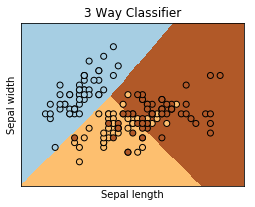

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data[:, :2]  # We only take the first two features.
Y = iris.target

h = .02  # Step size in the mesh

model = linear_model.LogisticRegression(C=1e5)

# We create an instance of Neighbours Classifier and fit the data.
model.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('3 Way Classifier')
plt.show()

Now that we have a model, we need to create the function that we will deploy to Clipper. We know that our function takes an array of length 2 - a petal width and a sepal length - and returns a label, so we can just define our `predict_label` function as shown below:

In [30]:
def predict_label(flower):
    if (len(flower) != 2):
        return 'Invalid argument passed!'
    return model.predict(flower)

To improve performance during inference, many machine learning models exploit opportunities for data parallelism in the inference process. Because of this, Clipper tries to provide multiple inputs at once to a deployed model. Therefore, models deployed to Clipper must have a function interface that takes a list of inputs as an argument and returns a list of predictions as strings. Returning predictions as strings provides a lot of flexibility over what your models can return. Commonly, models in Clipper will return either a single number (such as a label or score) or JSON containing a richer representation of the model output (for example, by including confidence estimates of predicted labels).

Starting version 0.3.0, Clipper not only supports batching, but also performs adaptive batching. To perform adaptive batching, Clipper sends different batch sizes to models in order to determine which batch size is optimal, and therefore it is imperative to treat the input to the predict function as a batch. We will go into more detail about using batching with Clipper in a later section.

We redefine our `predict_label` function, this time calling it `predict_flower`, to support this API. Since we are returning a string anyways, we might as well convert the labels given to us by our model to the corresponding flower name.

In [33]:
def predict_flower(flowers):
    labels = model.predict(flowers)
    return ['Setosa' if l == 0 else 'Versicolour' if l == 2 else 'Virginica' for l in labels]

In [35]:
# Just a quick test

assert predict_flower([X[0], X[100]]) == ['Setosa', 'Versicolour']

Now that we have a valid function, we proceed to the deployment stage!

### Deploying a model

One of the goals of Clipper is to make it simple to deploy and maintain machine-learning models in production. The prediction interface that models must implement is very simple, consisting of a single function. And the use of Docker makes it easy to include all of a model's dependencies in a self-contained environment. However, deploying a new type of model still entails writing and debugging a new model container and creating a Docker image.
To make the model deployment process even simpler, Clipper provides a library of model deployers for common types of models. If your model can be deployed with one of these deployers, you no longer need to write a model container, create a Docker image, or even figure out how to save a model. Instead, you provide your trained model directly to the model deployer function within your Python process. The model deployer takes care of saving the model and building a Docker image that is compatible with your model type.

Clipper provides model deployers for many common ML packages including PySpark, ONNX, TensorFlow, etc. In addition, Clipper provides a model deployer (the `PythonClosureContainer`) that can deploy arbitrary Python functions, and the ability to write custom containers for unsupported models.

To keep the base images light, Clipper model containers install only the required dependencies to ensure that a basic model will run. Starting in version 0.3.0, users are also offered the ability to specify packages to install via pip on new model containers during their startup using the `pkgs_to_install` keyword argument. This feature is in all model containers, and today, we will use it with the `PythonClosureContainer` to deploy our Scikit-Learn model.

Some models, such as those provided by Scikit-Learn or XGBoost, can be pickled, and require only that the packages are installed, and so these models can be deployed using the `PythonClosureContainer` and specifying that the packages are installed via the `pkgs_to_install` keyword argument, rather than creating custom model deployment containers.

For more information about model deployers, check out the docs on our [site](http://clipper.ai)!

In [38]:
from clipper_admin.deployers import python as python_deployer
python_deployer.deploy_python_closure(
    clipper_conn,
    name="flowercat",  # The name of the model in Clipper
    version=1,  # A unique identifier to assign to this model.
    input_type="floats",  # The type of data the model function expects as input
    func=predict_flower, # The model function to deploy
    pkgs_to_install=['numpy', 'scipy', 'scikit-learn'] # Packages to install in the new container. Must be a list
)

18-08-08:14:11:11 INFO     [deployer_utils.py:44] Saving function to /tmp/clipper/tmp582soptc
18-08-08:14:11:11 INFO     [deployer_utils.py:54] Serialized and supplied predict function
18-08-08:14:11:11 INFO     [python.py:192] Python closure saved
18-08-08:14:11:11 INFO     [python.py:206] Using Python 3.6 base image
18-08-08:14:11:11 INFO     [clipper_admin.py:452] Building model Docker image with model data from /tmp/clipper/tmp582soptc
18-08-08:14:11:24 INFO     [clipper_admin.py:456] {'stream': 'Step 1/3 : FROM clipper/python36-closure-container:0.3.0'}
18-08-08:14:11:24 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-08-08:14:11:24 INFO     [clipper_admin.py:456] {'stream': ' ---> 74ba26b9a6ba\n'}
18-08-08:14:11:24 INFO     [clipper_admin.py:456] {'stream': 'Step 2/3 : COPY /tmp/clipper/tmp582soptc /model/'}
18-08-08:14:11:24 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-08-08:14:11:24 INFO     [clipper_admin.py:456] {'stream': ' ---> 0713e04b6954\n'}
18-08-08:14:11:24 

Clipper deploys each model in its own Docker container. After deploying the model, Clipper uses the DockerContainerManager to start a container for this model and create an RPC connection with the Clipper query frontend, as illustrated below (the changes to the cluster are highlighted in red).

> *Once again, Clipper must download a Docker container from the internet the first time this command is run.*

![title](img/deploy_model.png)

If you list the Clipper containers again, you can see the container running your word count model.

In [39]:
!docker ps --filter label=ai.clipper.container.label

CONTAINER ID        IMAGE                               COMMAND                  CREATED             STATUS                    PORTS                                            NAMES
0612840303e8        flowercat:1                         "/container/containe…"   27 seconds ago      Up 26 seconds (healthy)                                                    flowercat_1-90909
46c39dee9218        prom/prometheus:v2.1.0              "/bin/prometheus --c…"   46 seconds ago      Up 44 seconds             0.0.0.0:9090->9090/tcp                           metric_frontend-97847
016ce6b9e3a3        clipper/frontend-exporter:0.3.0     "python /usr/src/app…"   46 seconds ago      Up 45 seconds                                                              query_frontend_exporter-89433
e8ce812c9197        clipper/query_frontend:0.3.0        "/clipper/release/sr…"   47 seconds ago      Up 46 seconds             0.0.0.0:1337->1337/tcp, 0.0.0.0:7000->7000/tcp   query_frontend-89433
1f27f5cb9c62        cli

#### A Note About Types [Optional]
When you deploy models and register applications, you must specify the input type that the model or application expects. The type that you specify has implications for how Clipper manages input serialization and deserialization. From the user's perspective, the input type affects the behavior of Clipper in two places. In the "input" field of the request JSON body, applications will reject requests where the value of that field is the wrong type. And the deployed model function will be called with a list of inputs of the specified type.

The input type can be one of the following types:

* "ints": The value of the "input" field in a request must be a JSON list of ints. The model function will be called with a list of numpy arrays of type numpy.int.
* "floats": The value of the "input" field in a request must be a JSON list of doubles. The model function will be called with a list of numpy arrays of type numpy.float32.
* "doubles": The value of the "input" field in a request must be a JSON list of doubles. The model function will be called with a list of numpy arrays of type numpy.float64.
* "bytes": The value of the "input" field in a request must be a Base64 encoded string. The model function will be called with a list of numpy arrays of type numpy.int8.
* "strings": The value of the "input" field in a request must be a string. The model function will be called with a list of strings.

## Registering an Application
You've now deployed a model to Clipper, but you don't have any way to query it yet. Instead of automatically creating a REST endpoint when you deploy a model, Clipper introduces a layer of indirection: the application. Clients query a specific application in Clipper, and the application routes the query to the correct model. This allows multiple applications to route queries to the same model, and allows a single application to route queries to multiple models.

A single Clipper cluster can have many applications registered and many models deployed at once.

When you register an application you configure certain elements of the application's behavior. These include:

* The name to give the REST endpoint.
* The input type that the application expects (Clipper will ensure applications only route requests to models with matching input types).
* The latency service level objective (SLO) specified in microseconds. Clipper will manage how it schedules and routes queries for an application based on the specified service level objective. For example, Clipper will set the amount of time it allows requests to spend queued before being sent to the model based on the service level objective for the application requesting the prediction. In addition, Clipper will respond to requests by the end of the specified SLO, even if it has not received a prediction back from the model.
* The default output: Clipper will respond with the default output to requests if a real prediction isn't available by the end of the service level objective.
* (In the future) The selection policy: The default or user defined model selection policy to use when determining which models to route requests to.

When you register an application with Clipper, it creates a REST endpoint for that application:

```
URL: /<app_name>/predict
Method: POST
Data Params: {"input": <input>}
```

To provide batch requests to clipper, you simply substitute `input` with `input_batch`. If both appear, `input` will be used, and `input_batch` ignored.

```
URL: /<app_name>/predict
Method: POST
Data Params: {"input_batch": <input_batch>}
```

![title](img/register_app.png)

Register an application to query your KMeans model:

In [40]:
clipper_conn.register_application(
    name="flowercat-app",
    input_type="floats",
    default_output="Default",
    slo_micros=100000)

18-08-08:14:12:07 INFO     [clipper_admin.py:201] Application flowercat-app was successfully registered


Try querying the newly created application. We use Python in this example, but it can also be done with [curl](https://curl.haxx.se)!

In [41]:
import requests, json
response = requests.post(
     "http://%s/%s/predict" % (clipper_addr, 'flowercat-app'),
     headers={"Content-type": "application/json"},
     data=json.dumps({
         'input': list(X[0]),
     }))
result = response.json()
result

{'default': True,
 'default_explanation': 'No connected models found for query',
 'output': 'Default',
 'query_id': 0}

You should see that your application returned the default output of "Default". This is because even though you have deployed a model and registered an application, you have not told Clipper to route requests from the "flowercat-app" application to the "flowercat" model.

You do this by linking the model to the application.

![title](img/link_model.png)

In [42]:
clipper_conn.link_model_to_app(app_name="flowercat-app", model_name="flowercat")

18-08-08:14:12:13 INFO     [clipper_admin.py:263] Model flowercat is now linked to application flowercat-app


When you query the "wordcount-app" endpoint again, Clipper should return the correct word count. Try it with your own input.

In [43]:
response = requests.post(
     "http://%s/%s/predict" % (clipper_addr, 'flowercat-app'),
     headers={"Content-type": "application/json"},
     data=json.dumps({
         'input': list(X[0]),
     }))
result = response.json()
result

{'default': False, 'output': 'Setosa', 'query_id': 1}

## Inspecting Clipper
The ClipperConnection object has several methods to inspect various aspects of the Clipper cluster.

You can list all of the applications.

In [44]:
clipper_conn.get_all_apps(verbose=True)

[{'default_output': 'Default',
  'input_type': 'floats',
  'latency_slo_micros': 100000,
  'linked_models': ['flowercat'],
  'name': 'flowercat-app'}]

Or all of the models.

In [45]:
clipper_conn.get_all_models(verbose=True)

[{'container_name': 'flowercat:1',
  'input_type': 'floats',
  'is_current_version': True,
  'labels': [''],
  'model_data_path': 'DEPRECATED',
  'model_name': 'flowercat',
  'model_version': '1'}]

Clipper also tracks several performance metrics that you can inspect at any time, as well as allows you to deploy your own custom metrics.

In [46]:
clipper_conn.inspect_instance()

{'counters': [{'internal:prediction_cache_lookups': {'count': '1'}},
  {'internal:aggregate_num_predictions': {'count': '1'}},
  {'model:flowercat:1:num_predictions': {'count': '2'}},
  {'app:flowercat-app:num_predictions': {'count': '2'}}],
 'histograms': [{'internal:rpc_request_queueing_delay': {'max': '70',
    'mean': '70',
    'min': '70',
    'p50': '70',
    'p95': '70',
    'p99': '70',
    'size': '1',
    'std_dev': '0',
    'unit': 'microseconds'}},
  {'model:flowercat:1:prediction_latency': {'max': '17756',
    'mean': '17756',
    'min': '17756',
    'p50': '17756',
    'p95': '17756',
    'p99': '17756',
    'size': '2',
    'std_dev': '0',
    'unit': 'microseconds'}},
  {'model:flowercat:1:batch_size': {'max': '2',
    'mean': '2',
    'min': '2',
    'p50': '2',
    'p95': '2',
    'p99': '2',
    'size': '1',
    'std_dev': '0',
    'unit': 'queries'}},
  {'app:flowercat-app:prediction_latency': {'max': '17961',
    'mean': '9235.5',
    'min': '510',
    'p50': '9235

You can also fetch the raw container logs from all of the Clipper docker containers. The command will print the paths to the log files for further examination. You can figure out which logs belong to which container based on the unique Docker container ID in the log filename.

In [47]:
clipper_conn.get_clipper_logs()

18-08-08:14:12:24 INFO     [docker_container_manager.py:295] Created logging directory: /Users/RehanDurrani/Documents/clipper-tutorials/clipper_logs


['/Users/RehanDurrani/Documents/clipper-tutorials/clipper_logs/image_sha256:6480c38708:container_0612840303.log',
 '/Users/RehanDurrani/Documents/clipper-tutorials/clipper_logs/image_sha256:c8ecf7c719:container_46c39dee92.log',
 '/Users/RehanDurrani/Documents/clipper-tutorials/clipper_logs/image_sha256:c29b40eb63:container_016ce6b9e3.log',
 '/Users/RehanDurrani/Documents/clipper-tutorials/clipper_logs/image_sha256:7eefa1a263:container_e8ce812c91.log',
 '/Users/RehanDurrani/Documents/clipper-tutorials/clipper_logs/image_sha256:3d960da25d:container_1f27f5cb9c.log',
 '/Users/RehanDurrani/Documents/clipper-tutorials/clipper_logs/image_sha256:4a1adec0b3:container_896337b691.log']

## Updating the Model
Machine learning models are rarely static. Instead, data science tends to be an iterative process, with new and improved models being developed over time. Clipper supports this workflow by letting you deploy new versions of models. If you look back to where you linked your flowercat model to the application, you'll see that there is no mention of versioning in that method call. Instead, when a new version of a model is deployed, Clipper will automatically start routing requests to the new version.

Create a new version of the "flowercat" model that returns the probabilities that an input is in each class instead.

In [52]:
def new_predict_flower(flowers):
    return model.predict_proba(flowers)

In [53]:
new_predict_flower([X[0]])

array([[ 0.9058239 ,  0.0681672 ,  0.02600889]])

Deploy this new version of the function as version "2". For this application, you are using a numeric versioning scheme. But Clipper just treats versions as unique string identifiers, so you could use other versioning schemes (such as Git hashes or semantic versioning). Versions don't even have to be ordered, Clipper just tracks the currently active version.

![title](img/update_model.png)


In [54]:
python_deployer.deploy_python_closure(
    clipper_conn,
    name="flowercat",  # The name of the model in Clipper
    version=2,  # A unique identifier to assign to this model.
    input_type="floats",  # The type of data the model function expects as input
    func=new_predict_flower, # The model function to deploy
    pkgs_to_install=['numpy', 'scipy', 'scikit-learn'] # Packages to install in the new container. Must be a list
)

18-08-08:14:16:00 INFO     [deployer_utils.py:44] Saving function to /tmp/clipper/tmp5pgek8xp
18-08-08:14:16:00 INFO     [deployer_utils.py:54] Serialized and supplied predict function
18-08-08:14:16:00 INFO     [python.py:192] Python closure saved
18-08-08:14:16:00 INFO     [python.py:206] Using Python 3.6 base image
18-08-08:14:16:00 INFO     [clipper_admin.py:452] Building model Docker image with model data from /tmp/clipper/tmp5pgek8xp
18-08-08:14:16:12 INFO     [clipper_admin.py:456] {'stream': 'Step 1/3 : FROM clipper/python36-closure-container:0.3.0'}
18-08-08:14:16:12 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-08-08:14:16:12 INFO     [clipper_admin.py:456] {'stream': ' ---> 74ba26b9a6ba\n'}
18-08-08:14:16:12 INFO     [clipper_admin.py:456] {'stream': 'Step 2/3 : COPY /tmp/clipper/tmp5pgek8xp /model/'}
18-08-08:14:16:12 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-08-08:14:16:12 INFO     [clipper_admin.py:456] {'stream': ' ---> 95e7fb7b74ec\n'}
18-08-08:14:16:12 

In [55]:
response = requests.post(
     "http://%s/%s/predict" % (clipper_addr, 'flowercat-app'),
     headers={"Content-type": "application/json"},
     data=json.dumps({
         'input': list(X[0]),
     }))
result = response.json()
result

{'default': False,
 'output': '[0.90582391 0.0681672  0.02600889]',
 'query_id': 2}

Sometimes the "new and improved" model is not actually improved. If you deploy a model that isn't working well, you can roll back to any previous version. This just changes which version of the model application's route requests to.

![title](img/rollback_version.png)

In [56]:
clipper_conn.set_model_version(name="flowercat", version="1")

In [57]:
response = requests.post(
     "http://%s/%s/predict" % (clipper_addr, 'flowercat-app'),
     headers={"Content-type": "application/json"},
     data=json.dumps({
         'input': list(X[0]),
     }))
result = response.json()
result

{'default': False, 'output': 'Setosa', 'query_id': 3}

## Adding Model Replicas
Many machine learning models are computationally expensive and a single instance of the model may not meet the throughput demands of a serving workload. To increase prediction throughput, you can add additional replicas of a model. This creates additional Docker containers running the same model. Clipper will act as a load-balancer and distribute incoming requests across the set of available model replicas to provide higher throughput.

Set the number of replicas for the currently active version ("1") of the "wordcount" model to 4.

![title](img/add_replicas.png)

In [58]:
clipper_conn.set_num_replicas("flowercat", num_replicas=4)

18-08-08:14:16:36 INFO     [docker_container_manager.py:257] Found 1 replicas for flowercat:1. Adding 3


If you list the Clipper Docker containers, you should now see four containers based on the image "flowercat:1".

In [59]:
!docker ps --filter label=ai.clipper.container.label

CONTAINER ID        IMAGE                               COMMAND                  CREATED             STATUS                    PORTS                                            NAMES
09baa2c4c0b4        flowercat:1                         "/container/containe…"   4 seconds ago       Up 3 seconds (healthy)                                                     flowercat_1-50819
f86aefd69899        flowercat:1                         "/container/containe…"   5 seconds ago       Up 4 seconds (healthy)                                                     flowercat_1-87296
92b73f812a5c        flowercat:1                         "/container/containe…"   5 seconds ago       Up 4 seconds (healthy)                                                     flowercat_1-679
bd8b97ff9a65        flowercat:2                         "/container/containe…"   29 seconds ago      Up 28 seconds (healthy)                                                    flowercat_2-12363
0612840303e8        flowercat:1             

If you want to reduce the number of replicas of a model to free up hardware resource, you can use the same command.

Set the number of replicas for "flowercat" back to 1.

![title](img/set_replicas.png)

In [60]:
clipper_conn.set_num_replicas("flowercat", num_replicas=1)

18-08-08:14:17:24 INFO     [docker_container_manager.py:278] Found 4 replicas for flowercat:1. Removing 3


In [61]:
!docker ps --filter label=ai.clipper.container.label

CONTAINER ID        IMAGE                               COMMAND                  CREATED              STATUS                        PORTS                                            NAMES
09baa2c4c0b4        flowercat:1                         "/container/containe…"   About a minute ago   Up About a minute (healthy)                                                    flowercat_1-50819
bd8b97ff9a65        flowercat:2                         "/container/containe…"   About a minute ago   Up About a minute (healthy)                                                    flowercat_2-12363
46c39dee9218        prom/prometheus:v2.1.0              "/bin/prometheus --c…"   6 minutes ago        Up 6 minutes                  0.0.0.0:9090->9090/tcp                           metric_frontend-97847
016ce6b9e3a3        clipper/frontend-exporter:0.3.0     "python /usr/src/app…"   6 minutes ago        Up 6 minutes                                                                   query_frontend_exporter-89433
e